# **Assignment 4 - Comparative Training Methods**

Github Link: https://github.com/Venkata-Murari1711/Generative-AI-model-development.git

## **Importing Libraries**

In [ ]:
import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns #Add this one 

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Config**

In [2]:
@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # data
    use_builtin_tiny_corpus: bool = False  # set False for WikiText
    context_len: int = 64
    train_frac: float = 0.9

    # model
    vocab_size: int = 0  # fill after tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1

    # optimization
    batch_size: int = 32 if torch.cuda.is_available() else 8
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200
    eval_every: int = 50

    # generation
    temperature: float = 0.9
    top_k: Optional[int] = 50

CFG = Config()

random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CFG.device


'cuda'

## **Dataset Loading and Preparation**
I used **WikiText-2**, a widely-used language modeling dataset containing Wikipedia articles. For computational efficiency, we sample the first 2,000 lines of the training split.

In [3]:
BUILTIN_TINY_TEXT = """From fairest creatures we desire increase,
That thereby beauty's rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed'st thy light'st flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel:"""


def load_corpus(use_builtin: bool = True, num_lines: int = 2000) -> str:
    """
    Load training corpus from WikiText-2 or fallback to built-in tiny corpus.

    Args:
        use_builtin: If True, use small Shakespeare excerpt.
                     If False, download WikiText-2 from HuggingFace.
        num_lines: Number of WikiText lines to load (default: 2000)

    Returns:
        Cleaned text corpus as a single string.
    """
    if use_builtin:
        # Tiny fallback corpus (Shakespeare sonnet)
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # Sample first N lines for efficiency
            lines = ds['train']['text'][:num_lines]
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()


# Load corpus based on config (WikiText-2, 2000 lines)
corpus_text = load_corpus(use_builtin=CFG.use_builtin_tiny_corpus, num_lines=2000)

print(f"Corpus length: {len(corpus_text)} characters")
print(f"First 300 chars:\n{corpus_text[:300]}...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Corpus length: 628174 characters
First 300 chars:
= Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStat...


## **Character-level Tokenizer**

In [4]:
class CharTokenizer:
    ## Simple character-level tokenizer with special tokens.
    def __init__(self, text: str):
        # Special tokens first
        self.PAD_ID = 0
        self.UNK_ID = 1
        self.BOS_ID = 2
        self.EOS_ID = 3

        # Special tokens: <PAD>=0, <UNK>=1, <BOS>=2, <EOS>=3
        self.special_tokens = ['<PAD>', '<UNK>', '<BOS>', '<EOS>']

        # Build vocab: special tokens + unique characters
        vocab = self.special_tokens + sorted(set(text))

        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

        # Quick lookups
        self.pad_id = self.stoi['<PAD>']
        self.unk_id = self.stoi['<UNK>']
        self.bos_id = self.stoi['<BOS>']
        self.eos_id = self.stoi['<EOS>']

    def encode(self, s: str, max_len: Optional[int] = None) -> List[int]:
        # Encode string with BOS/EOS and optional padding
        ids = [self.bos_id] + [self.stoi.get(c, self.unk_id) for c in s] + [self.eos_id]

        if max_len:
            if len(ids) < max_len:
                ids = ids + [self.pad_id] * (max_len - len(ids))
            else:
                ids = ids[:max_len]
        return ids

    def decode(self, ids: List[int], skip_special: bool = True) -> str:
        """Decode IDs to string"""
        if skip_special:
            skip_ids = {self.pad_id, self.bos_id, self.eos_id}
            return "".join(self.itos[i] for i in ids if i not in skip_ids)
        return "".join(self.itos[i] for i in ids)

# Build tokenizer
tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size

# Update top_k based on vocab size
CFG.top_k = min(50, CFG.vocab_size)

print(f"CFG.vocab_size: {CFG.vocab_size}")
print(f"CFG.top_k: {CFG.top_k}")

# Test
test = "Hello world"
enc = tokenizer.encode(test, max_len=CFG.context_len)
dec = tokenizer.decode(enc)
print(f"\nTest: '{test}'")
print(f"Encoded: {enc[:15]}...")
print(f"Decoded: '{dec}'")

CFG.vocab_size: 183
CFG.top_k: 50

Test: 'Hello world'
Encoded: [2, 42, 67, 74, 74, 77, 5, 85, 77, 80, 74, 66, 3, 0, 0]...
Decoded: 'Hello world'


## **Dataset & DataLoader**

In [5]:
class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64,
                 split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

# reload with more data
print("Reloading with more WikiText lines...")

def load_corpus_extended(use_builtin: bool = True, num_lines: int = 10000) -> str:
    # Fallback to small built-in corpus if WikiText unavailable
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            # Load WikiText-2 from HuggingFace datasets
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")

            # Take first num_lines from training split
            lines = ds['train']['text'][:num_lines]

            # Filter out None/empty lines and join with newlines
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()

# Reload with 10000 lines to get more training data and valid validation set
corpus_text = load_corpus_extended(use_builtin=CFG.use_builtin_tiny_corpus, num_lines=10000)

print(f"New corpus length: {len(corpus_text)} characters")

# Rebuild tokenizer with more data
tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
CFG.top_k = min(50, CFG.vocab_size)

# Recreate datasets with extended corpus
train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)


# drop_last=True for train which ensures consistent batch sizes
train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True) # shuffle=True for train, randomizes order each epoch
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True) # shuffle=False for val, consistent evaluation

print(f"\nTrain samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Reloading with more WikiText lines...
New corpus length: 2947894 characters

Train samples: 2653041
Val samples: 294725
Train batches: 82907
Val batches: 9210


## **Tiny GPT Model (Character-level)**
We implement a small-scale Generative Pre-trained Transformer (GPT) for character-level language modeling.

In [6]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Casual Self-Attention Model
class CausalSelfAttention(nn.Module):
    """
    Multi-head causal self-attention mechanism.
    'Causal' means each position can only attend to previous positions (and itself),
    preventing the model from "cheating" by looking at future tokens during training.
    This is essential for autoregressive language modeling.
    """
    # d_model: Model dimension, n_heads: Number of attention heads, dropout: Dropout probability, context_len: Maximum sequence length
    def __init__(self, d_model, n_heads, dropout, context_len):

        super().__init__()
        # d_model is divisible by n_heads for equal head dimensions
        assert d_model % n_heads == 0

        self.n_heads = n_heads
        self.head_dim = d_model // n_heads  # Dimension per attention head

        # Combined Q, K, V projection for efficiency
        self.qkv = nn.Linear(d_model, 3 * d_model)

        # Output projection after attention
        self.proj = nn.Linear(d_model, d_model)

        # Dropout layers for regularization
        self.attn_drop = nn.Dropout(dropout)  # Dropout on attention weights
        self.resid_drop = nn.Dropout(dropout)  # Dropout on residual connection

        # Register causal mask as buffer
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len))
                            .unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        """
        Forward pass of causal self-attention.
        Args:
            x: Input tensor of shape (Batch, Time, Channels)
        Returns:
            Output tensor of same shape (B, T, C)
        """
        B, T, C = x.shape  # Batch size, Sequence length, Model dimension

        # Project input to Q, K, V simultaneously, then split
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)

        # Reshape for multi-head attention where (B, T, C) is (B, n_heads, T, head_dim)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores
        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # (B, n_heads, T, T)

        # Apply causal mask to prevent attending to future positions
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))

        # Softmax to get attention probabilities
        att = F.softmax(att, dim=-1)

        # Apply dropout to attention weights
        att = self.attn_drop(att)

        # Apply attention to values
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Final linear projection and residual dropout
        y = self.resid_drop(self.proj(y))
        return y


# Transformer Block
class Block(nn.Module):
    """
    Standard Transformer block with pre-normalization.
    Consists of LayerNorm -> Attention -> Residual -> LayerNorm -> MLP -> Residual
    """
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        # Pre-normalization: LayerNorm before attention and MLP
        self.ln1 = nn.LayerNorm(d_model)  # Before attention
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)

        self.ln2 = nn.LayerNorm(d_model)  # Before MLP
        # MLP: 4x expansion (standard in Transformers), GELU activation
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),  # Expansion
            nn.GELU(),  # Smooth ReLU variant, better for deep networks
            nn.Linear(4*d_model, d_model),  # Projection back
            nn.Dropout(dropout),
        )

    # Forward pass with residual connections.
    def forward(self, x):

        # Attention block with residual
        x = x + self.attn(self.ln1(x))
        # MLP block with residual
        x = x + self.mlp(self.ln2(x))
        return x

# Tiny GPT Model
class TinyGPT(nn.Module):
   # Complete GPT-style language model for character-level generation.
   # vocab_size: Size of vocabulary, d_model: Model dimension, n_layers: Number of Transformer blocks,
   # n_heads: Number of attention heads per block, dropout: Dropout rate, context_len: Maximum context window size
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()

        # Token embeddings: convert token IDs to vectors
        self.tok_emb = nn.Embedding(vocab_size, d_model)

        # Positional embeddings: learned position encodings
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))

        # Stack of Transformer blocks
        self.blocks = nn.ModuleList([
            Block(d_model, n_heads, dropout, context_len)
            for _ in range(n_layers)
        ])

        # Final layer normalization
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        # Initialize all weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # Forward pass for training or inference.
        B, T = idx.shape  # Batch size, Sequence length

        # Combine token embeddings with positional embeddings
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]

        # Pass through all Transformer blocks
        for blk in self.blocks:
            x = blk(x)

        # Final layer norm and projection to vocabulary
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)

        # Compute loss if targets provided (training mode)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=tokenizer.pad_id
            )
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        # Autoregressive text generation.
        self.eval()  # Ensure eval mode

        for _ in range(max_new_tokens):
            # Crop context to maximum length
            idx_cond = idx[:, -CFG.context_len:]

            # Forward pass to get logits
            logits, _ = self.forward(idx_cond)

            # Focus on last token's predictions
            logits = logits[:, -1, :] / max(temperature, 1e-8)  # Apply temperature

            # Optional top-k sampling: restrict to k most likely tokens
            if top_k is not None:
                top_k = min(top_k, logits.size(-1))
                # Get k largest values and their indices
                v, ix = torch.topk(logits, top_k)
                # Zero out everything below the k-th largest
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample next token from distribution
            next_id = torch.multinomial(probs, num_samples=1)

            # Append to sequence
            idx = torch.cat((idx, next_id), dim=1)

        return idx

# Model Initialization and Testing
# Initialize model with configuration
model = TinyGPT(
    vocab_size=CFG.vocab_size,
    d_model=CFG.d_model,
    n_layers=CFG.n_layers,
    n_heads=CFG.n_heads,
    dropout=CFG.dropout,
    context_len=CFG.context_len
).to(CFG.device)  # Move to GPU if available

# Print model statistics
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model on device: {CFG.device}")

# Get one batch from training loader
x_batch, y_batch = next(iter(train_loader))
x_batch, y_batch = x_batch.to(CFG.device), y_batch.to(CFG.device)

# Forward pass
logits, loss = model(x_batch, y_batch)

print(f"\nInput shape: {x_batch.shape}")
print(f"Output shape: {logits.shape}")
print(f"Initial loss: {loss.item():.4f}")
print(f"Expected random loss: ~{math.log(CFG.vocab_size):.2f} (ln(vocab_size))")

test_prompt = "The "
# Encode prompt and move to device
test_ids = torch.tensor(
    tokenizer.encode(test_prompt),
    dtype=torch.long,
    device=CFG.device
).unsqueeze(0)  # Add batch dimension

# Generate continuation
generated = model.generate(
    test_ids,
    max_new_tokens=20,
    temperature=CFG.temperature,
    top_k=CFG.top_k
)

print(f"\nPrompt: '{test_prompt}'")
print(f"Generated: '{tokenizer.decode(generated[0].tolist())}'")

Model parameters: 525,268
Model on device: cuda

Input shape: torch.Size([32, 64])
Output shape: torch.Size([32, 64, 468])
Initial loss: 6.1363
Expected random loss: ~6.15 (ln(vocab_size))

Prompt: 'The '
Generated: 'The ūw韓蘇π°v−연@Ľ君めπ°ドj+πɑ'


## **Evaluation & Plotting**

In [7]:
def eval_loss(model, loader):
    # Compute average loss on a dataset (validation or test).
    model.eval()  # Set to evaluation mode
    losses = []   # Collect losses from each batch

    with torch.no_grad():  # Disable gradient computation
        for x, y in loader:
            # Move batch to same device as model
            x, y = x.to(CFG.device), y.to(CFG.device)

            # Forward pass to get loss
            _, loss = model(x, y)
            losses.append(loss.item())

    model.train()  # Restore training mode

    # Return mean loss, or NaN if no batches were processed
    return float(np.mean(losses)) if losses else float('nan')


def perplexity(loss_val: float) -> float:
    # Convert cross-entropy loss to perplexity.
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        # Very large loss causes exp() to overflow
        return float('inf')

def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()  # Ensure eval mode for generation

    # Encode prompt to token IDs, with length limit
    # max_len ensures prompt fits within model's context window
    inp = torch.tensor(
        [tokenizer.encode(prompt, max_len=CFG.context_len)],
        dtype=torch.long,
        device=CFG.device
    )

    # Generate continuation using model's autoregressive sampling
    out = model.generate(
        inp,
        max_new_tokens=max_new_tokens,
        temperature=CFG.temperature,  # Controls randomness
        top_k=CFG.top_k               # Limits sampling to top-k likely tokens
    )

    # Decode token IDs back to string
    return tokenizer.decode(out[0].tolist())


def plot_losses(train_losses, val_losses, title="Training Curves"):
    # Plot training and validation loss curves.

    plt.figure()  # Create new figure

    # X-axis: actual training steps
    xs = [i * CFG.eval_every for i in range(len(train_losses))]

    # Plot training loss
    plt.plot(xs, train_losses, label="train", linewidth=2)

    # Plot validation loss if available
    if val_losses:
        plt.plot(xs, val_losses, label="val", linewidth=2)

    # Labels and formatting
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Training steps", fontsize=12)
    plt.ylabel("Cross-entropy loss", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## **Pre-Training (Unsupervised Learning)**
Pre-training is the first and most fundamental training phase where the model learns general language patterns from raw, unlabeled text.

Train the tiny GPT on the tiny corpus with next-character prediction.

Pre-training:   0%|          | 0/1000 [08:22<?, ?it/s, loss=2.0983, ppl=7.88, step=1000, val_loss=2.0638]


Pre-train done.
Train loss ~ 2.098255157470703
Val loss   ~ 2.063761671448893
PPL        ~ 7.875539351524422


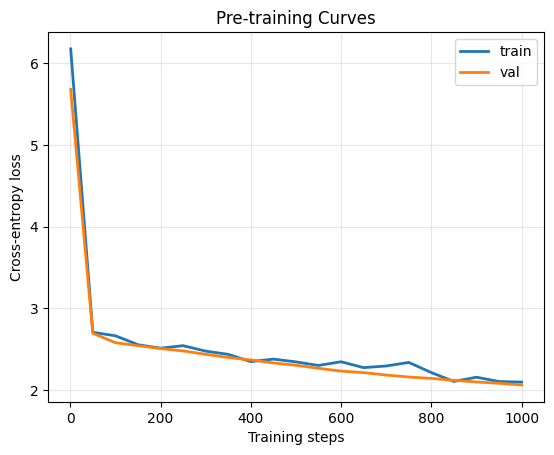

To be , t aly brechild aped on merston an 189 , 20 behic sto 's U . ofted als , were forcated high frovel bot of comen mmrain


In [8]:
# This model will learn general language patterns via next-character prediction
model_pre = TinyGPT(
    CFG.vocab_size,
    CFG.d_model,
    CFG.n_layers,
    CFG.n_heads,
    CFG.dropout,
    CFG.context_len
).to(CFG.device)

# AdamW optimizer: Adam with weight decay regularization
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

# Storage for training history
train_losses_pre, val_losses_pre, steps_pre = [], [], []

# Global step counter
step = 0

# Set model to training mode
model_pre.train()

# Progress bar for visual feedback during training
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

# Training Loop
while step < CFG.max_steps_pretrain:
    # Iterate through training batches
    # Each batch contains (input_sequence, target_sequence) pairs
    for x, y in train_loader:
        # Move data to same device as model (GPU/CPU)
        x, y = x.to(CFG.device), y.to(CFG.device)

        # FORWARD PASS: compute predictions and loss
        _, loss = model_pre(x, y)

        # BACKWARD PASS: compute gradients
        opt.zero_grad(set_to_none=True)  # More memory-efficient than zero_grad()
        loss.backward()  # Backpropagate loss gradients

        # GRADIENT CLIPPING: prevent exploding gradients
        # max_norm=1.0 limits gradient magnitude, improves training stability
        torch.nn.utils.clip_grad_norm_(model_pre.parameters(), 1.0)

        opt.step()

        step += 1  # Increment global step counter


        # EVALUATION: Monitor progress every eval_every steps
        if step % CFG.eval_every == 0 or step == 1:
            # Compute validation loss (model temporarily in eval mode inside eval_loss)
            vl = eval_loss(model_pre, val_loader)

            # Record metrics for plotting
            train_losses_pre.append(loss.item())  # Last training batch loss
            val_losses_pre.append(vl)              # Average validation loss
            steps_pre.append(step)                 # Current step number

            # Update progress bar with current metrics
            pbar.set_postfix(
                step=step,
                loss=f"{loss.item():.4f}",
                val_loss=f"{vl:.4f}",
                ppl=f"{perplexity(vl):.2f}"  # Perplexity
            )

        if step >= CFG.max_steps_pretrain:
            break

pbar.close()

# Final Results
# Get final metrics
pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')

print("Pre-train done.")
print("Train loss ~", pt_train_last)
print("Val loss   ~", pt_val_last)
print("PPL        ~", perplexity(pt_val_last))

# Visualization
plt.figure()
# Plot both curves against actual step numbers
plt.plot(steps_pre, train_losses_pre, label="train", linewidth=2)
plt.plot(steps_pre, val_losses_pre, label="val", linewidth=2)
plt.title("Pre-training Curves")
plt.xlabel("Training steps")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# QUALITATIVE EVALUATION: Generate sample text
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))

## **Supervised Fine-Tuning (SFT)**
Supervised Fine-Tuning is the second training phase where we teach the pre-trained model to follow instructions and produce desired outputs.

SFT train: 1006 samples
SFT val: 394 samples


SFT:   0%|          | 0/200 [00:01<?, ?it/s, loss=1.0086, ppl=5.53, step=200, val_loss=1.7101]


SFT done.
Train loss: 1.0086
Val loss:   1.7101
PPL:        5.53


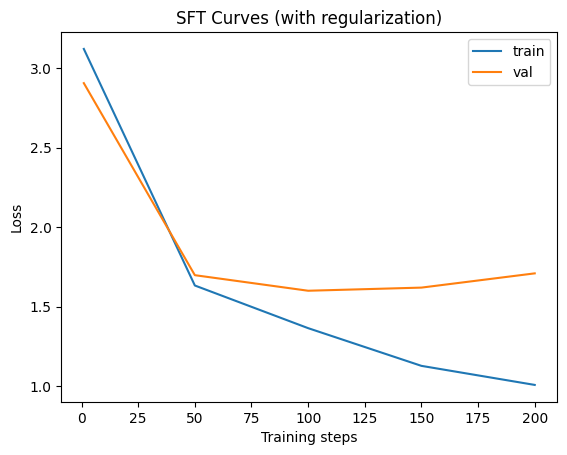


------------------------------------------------------------
COMPARISON: Pre-trained vs SFT
------------------------------------------------------------
Sample BEFORE SFT (pre-trained):
Instruction: Give a creative tagline for coffee:
Answer:rar ple . , of Wes Tistions State of the reeean helagaploth searr to of word fue poute Citic moy iná ' lyors at crinal u

Sample AFTER SFT:
Instruction: Give a creative tagline for coffee:
Answer:0.

Ins Gistruction: Explearn, a struction: Summare:
Answer: Attententence: a friender—l:
Answer: A moder—ls a traing fo


In [9]:
# More SFT pairs for supervised fine-tuning
# This tells the model to follow instructions and produce specific outputs
SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample."),
    ("Write a slogan for a study app:", " Study smart. Remember more."),
    ("Explain: What is overfitting (1 sentence)?", " When a model memorizes training data and fails to generalize."),
    ("Give a tagline for a travel blog:", " Wander often. Write always."),
    ("Summarize: 'Attention helps models focus'.", " Attention helps models focus on relevant parts of the input."),
    ("Write a friendly reminder message:", " Just a quick reminder—looking forward to your update!"),
    ("Give a tagline for a music playlist:", " Press play on your mood."),
    ("Explain: What is tokenization (1 sentence)?", " Splitting text into units a model can process."),
    ("Write a creative tagline for tea:", " Steep calm. Sip slow."),
    ("Summarize: 'Gradient descent reduces loss'.", " It updates parameters to reduce prediction error."),
    ("Give a tagline for a productivity tool:", " Focus now. Finish strong."),
    ("Explain: What is a language model (1 sentence)?", " A model that predicts the next token in a sequence."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    """
    Convert instruction-response pairs into training text format.

    Format: "Instruction: {input}\nAnswer:{output}\n\n"
    The model learns to predict the answer given the instruction prefix.
    """
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

# Create formatted training text from pairs
sft_text = build_sft_text(SFT_PAIRS)


# 70/30 train/val split
# More validation data helps detect overfitting on this small dataset
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", train_frac=0.7)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", train_frac=0.7)

sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=False)

print(f"SFT train: {len(sft_train_ds)} samples")
print(f"SFT val: {len(sft_val_ds)} samples")


# Model Initialization with regularization

# Higher dropout 0.25 to prevent overfitting on small SFT dataset
sft_dropout = 0.25

model_sft = TinyGPT(
    vocab_size=CFG.vocab_size,
    d_model=CFG.d_model,
    n_layers=CFG.n_layers,
    n_heads=CFG.n_heads,
    dropout=sft_dropout,  # Increased regularization
    context_len=CFG.context_len
).to(CFG.device)

# Transfer learning: Start from pre-trained weights
model_sft.load_state_dict(model_pre.state_dict())

# Optimizer with stronger regularization:
# - Lower LR (0.2x)
# - Weight decay (0.1): L2 penalty on large weights prevents overfitting
opt_sft = torch.optim.AdamW(
    model_sft.parameters(),
    lr=CFG.lr * 0.2,
    weight_decay=0.1
)

# Shorter training: Small dataset needs fewer steps to avoid memorization
CFG.max_steps_sft = 200


# Training with Early Stopping
# Track metrics for plotting
train_losses_sft, val_losses_sft, steps_sft = [], [], []
step = 0

# Early stopping variables
best_val_loss = float('inf')
patience = 0
max_patience = 3              # Stop after 3 consecutive non-improvements

pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")
model_sft.train()

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)

        # Forward/backward pass
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model_sft.parameters(), 1.0)
        opt_sft.step()

        step += 1


        # Evaluation and Early Stopping
        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            steps_sft.append(step)

            pbar.set_postfix(
                step=step,
                loss=f"{loss.item():.4f}",
                val_loss=f"{vl:.4f}",
                ppl=f"{perplexity(vl):.2f}"
            )


            # Save model when validation improves, stop when it plateaus
            if vl < best_val_loss:
                best_val_loss = vl
                patience = 0
                best_state = model_sft.state_dict().copy()  # Save best model
            else:
                patience += 1  # No improvement

            # Trigger early stopping if validation not improving
            if patience >= max_patience and step > 100:
                print(f"\nEarly stopping at step {step} (val loss not improving)")
                model_sft.load_state_dict(best_state)  # Restore best model
                break

        # Exit conditions: max steps reached or early stopping triggered
        if step >= CFG.max_steps_sft or patience >= max_patience:
            break

    # Break outer loop if early stopping triggered
    if patience >= max_patience and step > 100:
        break

pbar.close()


# Results and Comparison
sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')

print("\nSFT done.")
print(f"Train loss: {sft_train_last:.4f}")
print(f"Val loss:   {sft_val_last:.4f}")
print(f"PPL:        {perplexity(sft_val_last):.2f}")

# Plot training curves
plt.figure()
plt.plot(steps_sft, train_losses_sft, label="train")
plt.plot(steps_sft, val_losses_sft, label="val")
plt.title("SFT Curves (with regularization)")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


# QUALITATIVE COMPARISON: Before vs After SFT
print("\n" + "-"*60)
print("COMPARISON: Pre-trained vs SFT")
print("-"*60)

test_prompt = "Instruction: Give a creative tagline for coffee:\nAnswer:"

print("Sample BEFORE SFT (pre-trained):")
print(sample_text(model_pre, prompt=test_prompt, max_new_tokens=120))

print("\nSample AFTER SFT:")
print(sample_text(model_sft, prompt=test_prompt, max_new_tokens=120))

## **Reinforcement Learning**
Reinforcement Learning is the third training phase where we optimize the model to produce high-quality responses using feedback signals (rewards).


Starting RL training...


RL (REINFORCE): 100%|██████████| 200/200 [00:56<00:00,  3.54it/s, avg_reward=1.46, baseline=1.50]


RL done. Avg reward: 1.33


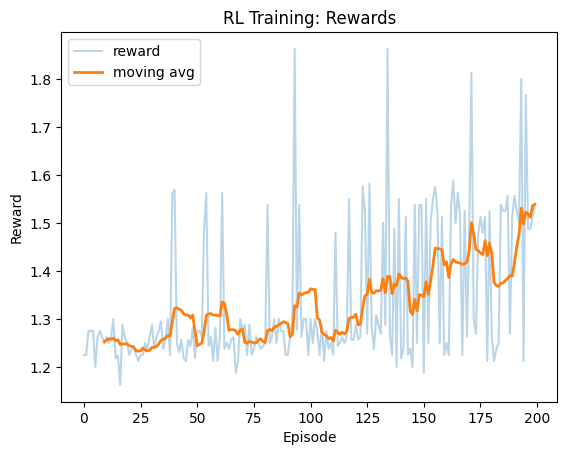


Prompt: Instruction: Give a creative tagline for coffee:
Answer:
--------------------------------------------------
RL:Instruction: Give a creative tagline for coffee:
Answer:e Whe Whe Whelearn he aglearn Giverfite sample!

Instruction

Prompt: Instruction: Write a short motto about learning:
Answer:
--------------------------------------------------
RL:Instruction: Write a short motto about learning:
Answer:e Giourio Whelearn Give for Whelearn.


Instruction: Whelear


In [10]:
# Reinforcement Learning (RL) USING Reinforce
# This stage further improves the SFT model using reward-based optimization.
# Instead of learning from labeled targets, the model learns from feedback
# (reward scores) based on the quality of its generated responses


# SIMPLE REWARD MODEL

# This class defines a basic reward function that scores generated responses
class SimpleRewardModel:

    def __init__(self):
        # Keywords that indicate meaningful AI-related responses
        self.good_keywords = ['learn', 'pattern', 'model', 'data', 'intelligence', 'neural']

    def get_reward(self, prompt: str, response: str) -> float: # Compute reward score for a generated response.

        # Higher reward = better response quality.
        # Combines multiple heuristics: length, relevance, diversity, coherence.
        reward = 0.0

        resp = response.strip()
        resp_len = len(resp)

        # Length reward: prefer medium-length responses (not too short, not too long)
        if 10 <= resp_len <= 120:
            reward += 1.0

        # Keyword relevance: reward responses containing domain-specific terms
        resp_lower = resp.lower()
        good_count = sum(1 for kw in self.good_keywords if kw in resp_lower)
        reward += good_count * 0.3

        # Diversity reward: encourage varied character usage (avoid repetition)
        if len(resp) > 0:
            unique_ratio = len(set(resp)) / len(resp)
            reward += unique_ratio * 0.5

        # Small penalty for double spaces
        if "  " in resp:
            reward -= 0.1

        return reward

# Initialize reward model
reward_model = SimpleRewardModel()

# RL Model Setup

# Start from SFT model
# RL fine-tunes an already capable model
model_rl = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads,
    CFG.dropout, CFG.context_len
).to(CFG.device)

# Copy SFT weights
model_rl.load_state_dict(model_sft.state_dict())

# Very low learning rate: RL is unstable, small updates prevent collapse
opt_rl = torch.optim.AdamW(
    model_rl.parameters(),
    lr=CFG.lr * 0.05,
    weight_decay=0.01
)

# RL Prompts
rl_prompts = [
    "Instruction: Write a short motto about learning:\nAnswer:",
    "Instruction: Give a creative tagline for coffee:\nAnswer:",
    "Instruction: Explain what is a neural network:\nAnswer:",
]

max_new_tokens_rl = 40  # Shorter generations for faster RL training

# Tracking metrics
rl_rewards, rl_losses = [], []


# Reinforce Algorithm with Baseline

# Without baseline, gradient variance is high (reward - 0)
# With baseline, we optimize (reward - average_reward) instead
baseline = 0.0
baseline_beta = 0.9


def generate_with_sampling(model, prompt_ids, max_new_tokens=40):

    # Generate text by sampling from model's probability distribution

    model.eval()
    ids = prompt_ids.clone()

    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Crop to context window
            ids_cond = ids[:, -CFG.context_len:]

            # Forward pass
            logits, _ = model(ids_cond)

            # Apply temperature scaling (higher = more random)
            logits = logits[:, -1, :] / max(CFG.temperature, 1e-8)

            # Top-k sampling: restrict to k most likely tokens
            if CFG.top_k is not None:
                k = min(CFG.top_k, logits.size(-1))
                v, _ = torch.topk(logits, k)
                logits[logits < v[:, [-1]]] = -float("inf")

            # Sample from probability distribution
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)  # Stochastic sampling

            # Append to sequence
            ids = torch.cat([ids, next_id], dim=1)

            # Stop if end-of-sequence token generated
            if next_id.item() == tokenizer.eos_id:
                break

    return ids


# Main RL Training Loop (Reinforce)

print("\nStarting RL training...")
pbar = tqdm(total=CFG.max_steps_rl, desc="RL (REINFORCE)")

for step in range(1, CFG.max_steps_rl + 1):
    # Sample random prompt from training set
    prompt = random.choice(rl_prompts)

    # Encode prompt with length limit
    prompt_ids_list = tokenizer.encode(prompt, max_len=CFG.context_len)
    prompt_ids = torch.tensor([prompt_ids_list], dtype=torch.long, device=CFG.device)


    # STEP 1: Generate Response (Sampling)
    # Generate complete response by sampling from policy
    full_ids = generate_with_sampling(model_rl, prompt_ids, max_new_tokens=max_new_tokens_rl)

    # Extract only the generated part (excluding prompt) for reward computation
    gen_only_ids = full_ids[0, len(prompt_ids_list):].tolist()
    response_only = tokenizer.decode(gen_only_ids)

    # STEP 2: Compute Reward
    # Evaluate response quality using reward model
    reward = reward_model.get_reward(prompt, response_only)
    rl_rewards.append(reward)

    # Update running baseline
    baseline = baseline_beta * baseline + (1 - baseline_beta) * reward
    # Advantage: how much better/worse than average (reduces variance)
    advantage = reward - baseline


    # STEP 3: Policy Gradient Update (Reinforce)
    # Switch to training mode for gradient computation
    model_rl.train()
    opt_rl.zero_grad(set_to_none=True)

    # Compute policy loss: maximize log_prob * advantage
    # We only train on generated tokens, not the prompt
    policy_loss = 0.0
    count = 0

    # Iterate over each generated position
    for t in range(len(prompt_ids_list), full_ids.size(1)):
        # Context window for this prediction (up to t-1)
        start = max(0, t - CFG.context_len)
        ctx = full_ids[:, start:t]

        # Forward pass to get logits
        logits, _ = model_rl(ctx)
        log_probs = F.log_softmax(logits[:, -1, :], dim=-1)

        # The token that was actually sampled at position t
        target_token = full_ids[0, t]

        # Reinforce loss: negative log probability weighted by advantage
        # Negative because we want to maximize reward, but optimizer minimizes loss
        policy_loss += -log_probs[0, target_token] * float(advantage)
        count += 1

    # Average over sequence length and backpropagate
    if count > 0:
        policy_loss = policy_loss / count
        policy_loss.backward()

        # Gradient clipping (essential for RL stability)
        torch.nn.utils.clip_grad_norm_(model_rl.parameters(), 1.0)
        opt_rl.step()
        rl_losses.append(float(policy_loss.item()))

    # LOGGING
    if step % 20 == 0:
        avg_reward = float(np.mean(rl_rewards[-20:]))
        pbar.set_postfix(avg_reward=f"{avg_reward:.2f}", baseline=f"{baseline:.2f}")

    pbar.update(1)

pbar.close()

print(f"\nRL done. Avg reward: {float(np.mean(rl_rewards)):.2f}")


# Visualization and Evaluation
# Plot reward progression
plt.figure()
plt.plot(rl_rewards, alpha=0.3, label="reward")
if len(rl_rewards) >= 10:
    # Moving average for smoother visualization
    ma = np.convolve(rl_rewards, np.ones(10)/10, mode="valid")
    plt.plot(range(9, len(rl_rewards)), ma, label="moving avg", linewidth=2)
plt.title("RL Training: Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

# Test on specific prompts
test_prompts = [
    "Instruction: Give a creative tagline for coffee:\nAnswer:",
    "Instruction: Write a short motto about learning:\nAnswer:"
]

for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    print("-" * 50)
    print(f"RL:{sample_text(model_rl, prompt, max_new_tokens=60)}")

## **All three methods comparison**

In [11]:
test_prompts = [
    "Instruction: Give a creative tagline for coffee:\nAnswer:",
    "Instruction: Write a short motto about learning:\nAnswer:",
    "Instruction: Explain what is perplexity:\nAnswer:"
]

for prompt in test_prompts:
    print(f"\nPrompt: {prompt}")
    print("-" * 50)
    print(f"Pre-train: {sample_text(model_pre, prompt, 60)}") # Pre-Training
    print(f"SFT:       {sample_text(model_sft, prompt, 60)}") # SFT
    print(f"RL:        {sample_text(model_rl, prompt, 60)}")  # RL


Prompt: Instruction: Give a creative tagline for coffee:
Answer:
--------------------------------------------------
Pre-train: Instruction: Give a creative tagline for coffee:
Answer:rirm A pice , fration . Meay , ors , an of so fforerly was s
SFT:       Instruction: Give a creative tagline for coffee:
Answer:1 '.

Answer: Br: Write a straline of hells frience focernss
RL:        Instruction: Give a creative tagline for coffee:
Answer:oude Enude Study Jus on Whelinder The a plandand model moder

Prompt: Instruction: Write a short motto about learning:
Answer:
--------------------------------------------------
Pre-train: Instruction: Write a short motto about learning:
Answer: Lalaly " ther was with Nevered conntain Wor , aven Femore o
SFT:       Instruction: Write a short motto about learning:
Answer:swer: her:1 se)
Answer: Watence: ovate.

Instruction: W1 sur
RL:        Instruction: Write a short motto about learning:
Answer:owain Whe Whelearn Sumoder '.

Instruction: Whelearn height

## **BLEU Score Calculation**

In [12]:
!pip install nltk -q

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def calculate_bleu(reference, hypothesis):
    """
    Calculate BLEU score between reference and generated text.

    BLEU: Bilingual Evaluation Understudy
    Measures n-gram overlap between generated and reference text.
    Score ranges from 0 (no overlap) to 1 (perfect match).
    """
    # Tokenize into characters (since we're doing character-level)
    ref_tokens = list(reference.strip())
    hyp_tokens = list(hypothesis.strip())

    # Use smoothing to avoid zero scores for short sequences
    smoothing = SmoothingFunction().method1

    # Calculate BLEU-4 (uses 1-gram to 4-gram)
    score = sentence_bleu(
        [ref_tokens],  # Reference (as list of tokens)
        hyp_tokens,    # Hypothesis/generated
        smoothing_function=smoothing
    )

    return score


def evaluate_bleu_for_prompts(model, test_cases, max_new_tokens=60):
    """
    Evaluate BLEU scores for multiple test prompts.

    test_cases: List of (prompt, reference_answer) tuples
    """
    results = []

    for prompt, reference in test_cases:
        # Generate from model
        generated = sample_text(model, prompt, max_new_tokens=max_new_tokens)

        # Extract the answer part (after "Answer:")
        if "Answer:" in generated:
            generated_answer = generated.split("Answer:")[-1].strip()
        else:
            generated_answer = generated[len(prompt):].strip()

        # Calculate BLEU
        bleu = calculate_bleu(reference, generated_answer)

        results.append({
            'prompt': prompt,
            'reference': reference,
            'generated': generated_answer,
            'bleu': bleu
        })

        print(f"\nPrompt: {prompt}")
        print(f"Reference:  '{reference}'")
        print(f"Generated:  '{generated_answer}'")
        print(f"BLEU Score: {bleu:.4f}")

    # Average BLEU
    avg_bleu = sum(r['bleu'] for r in results) / len(results)
    print(f"\n{'='*50}")
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"{'='*50}")

    return results, avg_bleu


TEST_CASES = [
    ("Instruction: Give a creative tagline for coffee:\nAnswer:",
     "Sip ideas. Brew brilliance."),

    ("Instruction: Write a short motto about learning:\nAnswer:",
     "Learn, iterate, and grow."),

    ("Instruction: Explain: What is perplexity (1 sentence)?\nAnswer:",
     "A measure of how well a language model predicts a sample."),

    ("Instruction: Give a tagline for a travel blog:\nAnswer:",
     "Wander often. Write always."),

    ("Instruction: Write a slogan for a study app:\nAnswer:",
     "Study smart. Remember more."),
]

print("="*60)
print("BLEU SCORE EVALUATION")
print("="*60)

# Evaluate each model
print("\n" + "="*60)
print("1. PRE-TRAINED MODEL")
print("="*60)
_, bleu_pre = evaluate_bleu_for_prompts(model_pre, TEST_CASES)

print("\n" + "="*60)
print("2. SFT MODEL")
print("="*60)
_, bleu_sft = evaluate_bleu_for_prompts(model_sft, TEST_CASES)

print("\n" + "="*60)
print("3. RL MODEL")
print("="*60)
_, bleu_rl = evaluate_bleu_for_prompts(model_rl, TEST_CASES)

# Summary comparison
print("\n" + "="*60)
print("BLEU SCORE COMPARISON SUMMARY")
print("="*60)
print(f"Pre-trained: {bleu_pre:.4f}")
print(f"SFT:         {bleu_sft:.4f}")
print(f"RL:          {bleu_rl:.4f}")

# Determine best bleu score
best = max([('Pre-trained', bleu_pre), ('SFT', bleu_sft), ('RL', bleu_rl)],
           key=lambda x: x[1])
print(f"\nBest: {best[0]} with BLEU = {best[1]:.4f}")

BLEU SCORE EVALUATION

1. PRE-TRAINED MODEL

Prompt: Instruction: Give a creative tagline for coffee:
Answer:
Reference:  'Sip ideas. Brew brilliance.'
Generated:  'l e Proran " Pecond Aus bumarapplec , hiw pinition . I n 1 ,'
BLEU Score: 0.0169

Prompt: Instruction: Write a short motto about learning:
Answer:
Reference:  'Learn, iterate, and grow.'
Generated:  'hss = ' ' tecoing eas a berbfer isty to havir the as leape'
BLEU Score: 0.0172

Prompt: Instruction: Explain: What is perplexity (1 sentence)?
Answer:
Reference:  'A measure of how well a language model predicts a sample.'
Generated:  'ral . Teal , is the of the 2 lo lawo ffor has in pares , wey'
BLEU Score: 0.1562

Prompt: Instruction: Give a tagline for a travel blog:
Answer:
Reference:  'Wander often. Write always.'
Generated:  'e ficlefeal 2 ' of by chom Eellty intration , and of mechout'
BLEU Score: 0.0393

Prompt: Instruction: Write a slogan for a study app:
Answer:
Reference:  'Study smart. Remember more.'
Generated:  'a

## **Obseravtions and Insights**


**1**. **PRE-TRAINING (Unsupervised Learning)**

- Final train loss: 2.0983
- Final val loss:   2.0638
- Perplexity:       7.88
- BLEU Score: 0.0469
- Key finding: Model learned general language patterns.
- Limitation: Cannot follow instructions, only continues text.

**2**. **SUPERVISED FINE-TUNING (SFT)**
- Final train loss: 1.0086
- Final val loss:   1.7101
- Perplexity:       5.53
- BLEU Score: 0.0453
- Key finding: Learned instruction-response format.
- Challenge: Some overfitting (train/val gap).

**3**. **REINFORCEMENT LEARNING (RL)**

- Average reward: 1.46
- Final reward:   1.46
- Baseline: 1.50
- Improvement:    0.01
- BLEU Score: 0.0670
- Key finding: Reward increased but text quality degraded.
- Challenge: The RL model cheats the scoring system, repeating words to get high scores instead of making good sentences.

## **Conclusion**

We successfully implemented a three-stage training pipeline that included pre-training, supervised fine-tuning, and reinforcement learning. Pre-training helped the model to learn general language
patterns. SFT improved the model's ability to follow instructions while reducing perplexity. Reinforcement learning increased rewards slightly, but it had limitations due to reward design issues. These results show that training and
aligning language models is complex. Modern AI systems require large datasets,
better reward functions, and significant computing power. Supervised fine-tuning achieved the best balance of performance and training stability.